In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import vgg16


target_shape = (96, 96)


In [2]:
cache_dir = r"C:\Users\sriba\Documents\Python Scripts\Siamese\One-Shot/Document"
anchor_images_path = cache_dir + "/anchor"
positive_images_path = cache_dir + "/positive"

In [3]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )


In [4]:
anchor_images = sorted(
    [str(anchor_images_path +'/'+ f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path +'/'+ f) for f in os.listdir(positive_images_path)]
)

In [5]:
anchor_images

['C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/anchor/A (1).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/anchor/A (10).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/anchor/A (11).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/anchor/A (12).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/anchor/A (13).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/anchor/A (14).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/anchor/A (15).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/anchor/A (16).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/anchor/A (17).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/anchor/A (18).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-S

In [6]:
positive_images

['C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/positive/A (1).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/positive/A (10).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/positive/A (11).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/positive/A (12).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/positive/A (13).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/positive/A (14).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/positive/A (15).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/positive/A (16).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/positive/A (17).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scripts\\Siamese\\One-Shot/Document/positive/A (18).jpg',
 'C:\\Users\\sriba\\Documents\\Python Scr

In [7]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )


In [8]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted([str(anchor_images_path +'/'+ f) for f in os.listdir(anchor_images_path)])

positive_images = sorted(
    [str(positive_images_path +'/'+ f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

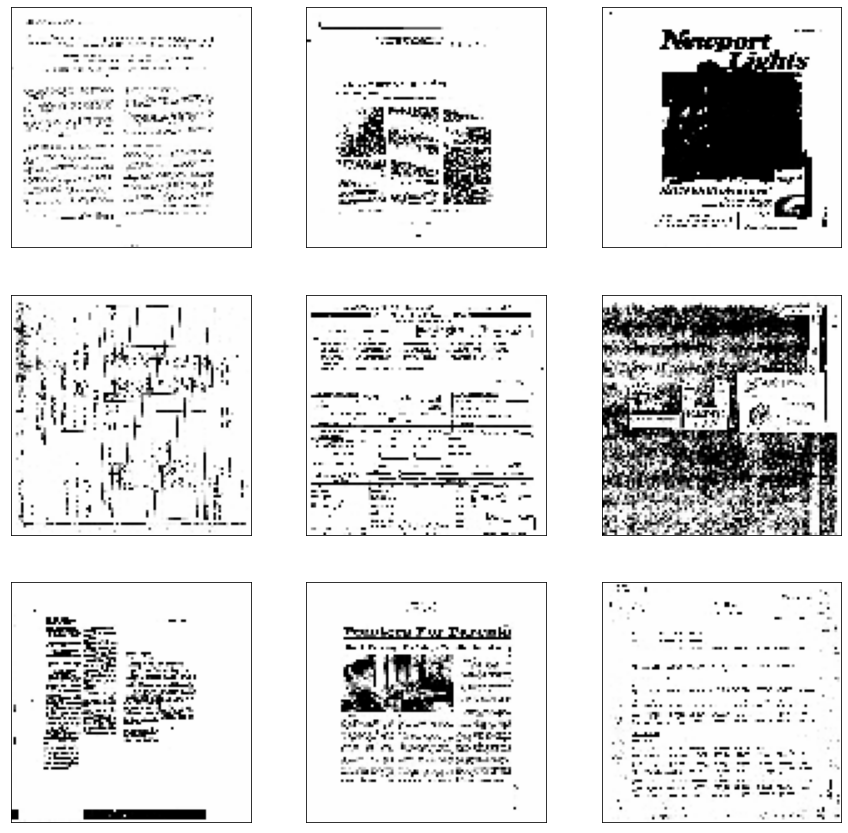

In [9]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(15, 15))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])


In [10]:
base_cnn = vgg16.VGG16(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(256, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

embedding.load_weights('twin.h5')

In [11]:
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [12]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(vgg16.preprocess_input(anchor_input)),
    embedding(vgg16.preprocess_input(positive_input)),
    embedding(vgg16.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [13]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [14]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 96, 96, 3)    0           anchor[0][0]                     
______________________________________________________________________________________________

In [16]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [18]:
history = siamese_model.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100
8/8 [==============================] - 41s 5s/step - loss: 0.5405 - val_loss: 0.5059
Epoch 2/100
8/8 [==============================] - 37s 5s/step - loss: 0.4833 - val_loss: 0.4576
Epoch 3/100
8/8 [==============================] - 37s 5s/step - loss: 0.4030 - val_loss: 0.4258
Epoch 4/100
8/8 [==============================] - 37s 5s/step - loss: 0.4206 - val_loss: 0.3407
Epoch 5/100
8/8 [==============================] - 37s 5s/step - loss: 0.4127 - val_loss: 0.3417
Epoch 6/100
8/8 [==============================] - 37s 5s/step - loss: 0.4338 - val_loss: 0.4683
Epoch 7/100
8/8 [==============================] - 37s 5s/step - loss: 0.4303 - val_loss: 0.3770
Epoch 8/100
8/8 [==============================] - 37s 5s/step - loss: 0.3954 - val_loss: 0.3534
Epoch 9/100
8/8 [==============================] - 37s 5s/step - loss: 0.4045 - val_loss: 0.3584
Epoch 10/100
8/8 [==============================] - 37s 5s/step - loss: 0.4037 - val_loss: 0.4108
Epoch 11/100
8/8 [===========

8/8 [==============================] - 37s 5s/step - loss: 0.2603 - val_loss: 0.3013
Epoch 85/100
8/8 [==============================] - 37s 5s/step - loss: 0.2265 - val_loss: 0.2956
Epoch 86/100
8/8 [==============================] - 37s 5s/step - loss: 0.2763 - val_loss: 0.2730
Epoch 87/100
8/8 [==============================] - 37s 5s/step - loss: 0.2398 - val_loss: 0.2244
Epoch 88/100
8/8 [==============================] - 37s 5s/step - loss: 0.2391 - val_loss: 0.2483
Epoch 89/100
8/8 [==============================] - 37s 5s/step - loss: 0.2516 - val_loss: 0.2554
Epoch 90/100
8/8 [==============================] - 37s 5s/step - loss: 0.2462 - val_loss: 0.2065
Epoch 91/100
8/8 [==============================] - 37s 5s/step - loss: 0.2456 - val_loss: 0.2149
Epoch 92/100
8/8 [==============================] - 37s 5s/step - loss: 0.2510 - val_loss: 0.2476
Epoch 93/100
8/8 [==============================] - 37s 5s/step - loss: 0.2752 - val_loss: 0.2478
Epoch 94/100
8/8 [===============

In [ ]:
embedding.save('twin_partial_96.h5')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()


In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(vgg16.preprocess_input(anchor)),
    embedding(vgg16.preprocess_input(positive)),
    embedding(vgg16.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())
